In [1]:
# Cell 1: Import libraries and your modules
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import your preprocessor and model classes
from preprocessor import EEGPreprocessor  # Your first file
from model import EEGNetv4, CSPFilter, CSPLayer, CSPNet1, CSPNet2  # Your second file

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class EEGDatasetWithICA(Dataset):
    def __init__(self, dataframe, base_path='.', task_filter='MI', 
                 use_preprocessing=True, preprocessor=None, verbose=False):
        """
        Enhanced EEG Dataset with ICA preprocessing integration
        
        Parameters:
        dataframe: pd.DataFrame, contains trial information
        base_path: str, path to dataset
        task_filter: str, filter by task ('MI' for Motor Imagery)
        use_preprocessing: bool, whether to apply ICA preprocessing
        preprocessor: EEGPreprocessor, fitted preprocessor instance
        verbose: bool, print preprocessing info
        """
        if task_filter:
            self.dataframe = dataframe[dataframe['task'] == task_filter].reset_index(drop=True)
        else:
            self.dataframe = dataframe
        
        self.base_path = base_path
        self.use_preprocessing = use_preprocessing
        self.preprocessor = preprocessor
        self.verbose = verbose
        self.eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
        
        # Label mapping for MI task
        self.label_mapping = {'Left': 0, 'Right': 1}
        
        # Store preprocessed data to avoid reprocessing
        self.preprocessed_cache = {}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        trial_id = row['id']
        
        # Check if already preprocessed
        if trial_id in self.preprocessed_cache:
            eeg_tensor = self.preprocessed_cache[trial_id]
        else:
            # Load and preprocess trial data
            trial_data = self.load_trial_data(row)
            eeg_data = trial_data[self.eeg_channels].values  # Shape: (samples, channels)
            
            if self.use_preprocessing and self.preprocessor is not None:
                # Apply full ICA preprocessing pipeline
                eeg_data, preprocessing_info = self.preprocessor.preprocess_trial(
                    trial_data
                )
            
            # Convert to tensor: (1, channels, samples) for CNN
            eeg_tensor = torch.FloatTensor(eeg_data.T).unsqueeze(0)  # (1, 8, 2250)
            
            # Cache preprocessed data
            self.preprocessed_cache[trial_id] = eeg_tensor
        
        # Get label
        label_str = row.get('label', 'Unknown')
        label = self.label_mapping.get(label_str, -1)
        
        return eeg_tensor, label, trial_id
    
    def load_trial_data(self, row):
        """Load trial data from CSV"""
        id_num = row['id']
        if id_num <= 4800:
            dataset = 'train'
        elif id_num <= 4900:
            dataset = 'validation'
        else:
            dataset = 'test'
        
        eeg_path = f"{self.base_path}/{row['task']}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        samples_per_trial = 2250 if row['task'] == 'MI' else 1750
        
        start_idx = (trial_num - 1) * samples_per_trial
        end_idx = start_idx + samples_per_trial - 1
        
        return eeg_data.iloc[start_idx:end_idx+1]

In [3]:
def prepare_data_for_csp(dataloader, verbose=True):
    """Prepare preprocessed data for CSP computation"""
    left_trials = []
    right_trials = []
    
    if verbose:
        print("Extracting preprocessed EEG data for CSP computation...")
    
    for data, labels, _ in tqdm(dataloader, desc="Loading data for CSP"):
        for i in range(data.shape[0]):
            eeg_data = data[i, 0, :, :].numpy()  # (channels, samples)
            if labels[i] == 0:  # Left
                left_trials.append(eeg_data)
            elif labels[i] == 1:  # Right
                right_trials.append(eeg_data)
    
    left_trials = np.array(left_trials)
    right_trials = np.array(right_trials)
    
    if verbose:
        print(f"Left trials: {left_trials.shape}")
        print(f"Right trials: {right_trials.shape}")
    
    return left_trials, right_trials

def compute_csp_filters(train_loader, n_components=8, verbose=True):
    """
    Compute CSP filters from preprocessed training data with improved error handling
    """
    if verbose:
        print("🧠 Computing CSP filters with robust implementation...")
    
    # Prepare data
    left_trials, right_trials = prepare_data_for_csp(train_loader, verbose)
    
    if len(left_trials) < 2 or len(right_trials) < 2:
        raise ValueError(f"Insufficient data: Left={len(left_trials)}, Right={len(right_trials)} trials")
    
    if verbose:
        print(f"Data summary:")
        print(f"  Left trials: {left_trials.shape}")
        print(f"  Right trials: {right_trials.shape}")
        print(f"  Left range: [{left_trials.min():.3f}, {left_trials.max():.3f}]")
        print(f"  Right range: [{right_trials.min():.3f}, {right_trials.max():.3f}]")
    
    # Use the robust CSP implementation
    csp = CSPFilter(n_components=n_components, reg=1e-6)
    csp.fit(left_trials, right_trials)
    
    if verbose:
        print(f"✅ CSP computation completed successfully!")
        print(f"Filter matrix shape: {csp.filters_.shape}")
        if len(csp.eigenvalues_) >= 5:
            print(f"Top 5 eigenvalues: {csp.eigenvalues_[:5]}")
            print(f"Bottom 5 eigenvalues: {csp.eigenvalues_[-5:]}")
    
    return csp

In [4]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, 
                device='cuda', patience=10, verbose=True):
    """Train the model with early stopping"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience//2, factor=0.5)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]') if verbose else train_loader
        for data, labels, _ in train_pbar:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]') if verbose else val_loader
            for data, labels, _ in val_pbar:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        
        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}')
            print(f'  Val Acc: {val_acc:.2f}%')
            print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping and best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            if verbose:
                print(f'  ✅ New best model! Validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f'  ⏰ Early stopping triggered after {patience} epochs without improvement')
                break
        
        if verbose:
            print('-' * 60)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses, val_accuracies

def evaluate_model(model, test_loader, device='cuda', verbose=True):
    """Evaluate the model"""
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_ids = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Evaluating") if verbose else test_loader
        for data, labels, ids in test_pbar:
            data = data.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_ids.extend(ids.numpy())
    
    # Calculate accuracy (only for labeled data)
    valid_indices = [i for i, label in enumerate(all_labels) if label != -1]
    if valid_indices:
        valid_labels = [all_labels[i] for i in valid_indices]
        valid_preds = [all_preds[i] for i in valid_indices]
        accuracy = accuracy_score(valid_labels, valid_preds)
        
        # Generate classification report
        target_names = ['Left', 'Right']
        report = classification_report(valid_labels, valid_preds, target_names=target_names)
        
        return accuracy, report, all_preds, valid_labels, all_ids
    else:
        return None, None, all_preds, all_labels, all_ids

In [5]:
def plot_training_results(results, title="Model Comparison"):
    """Plot training results for multiple models"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Plot validation accuracies
    for model_name, result in results.items():
        ax1.plot(result['val_accuracies'], label=model_name, linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Accuracy (%)')
    ax1.set_title('Validation Accuracy Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot final accuracies comparison
    model_names = list(results.keys())
    final_accs = [results[name]['accuracy'] for name in model_names if results[name]['accuracy'] is not None]
    valid_names = [name for name in model_names if results[name]['accuracy'] is not None]
    
    if final_accs:
        bars = ax2.bar(valid_names, final_accs, color=['blue', 'green', 'red'][:len(final_accs)])
        ax2.set_ylabel('Final Validation Accuracy')
        ax2.set_title('Final Model Performance')
        ax2.set_ylim([0, 1])
        
        # Add value labels on bars
        for bar, acc in zip(bars, final_accs):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    # Plot losses
    for model_name, result in results.items():
        ax3.plot(result['train_losses'], label=f'{model_name} Train', linestyle='--', alpha=0.7)
        ax3.plot(result['val_losses'], label=f'{model_name} Val')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Training and Validation Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Confusion matrix for best model
    if results:
        best_model_name = max(results.keys(), 
                            key=lambda x: results[x]['accuracy'] if results[x]['accuracy'] is not None else 0)
        best_result = results[best_model_name]
        
        if best_result['true_labels'] and best_result['predictions']:
            cm = confusion_matrix(best_result['true_labels'], 
                                [best_result['predictions'][i] for i in range(len(best_result['true_labels']))])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
                       xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
            ax4.set_title(f'Confusion Matrix - {best_model_name}')
            ax4.set_xlabel('Predicted')
            ax4.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def visualize_csp_filters(csp, eeg_channels, title="CSP Spatial Filters"):
    """Visualize CSP filters"""
    n_filters = min(8, csp.filters_.shape[1])
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    fig.suptitle(title, fontsize=16)
    
    for i in range(n_filters):
        filter_weights = csp.filters_[:, i]
        
        bars = axes[i].bar(eeg_channels, filter_weights, 
                          color=['red' if w < 0 else 'blue' for w in filter_weights])
        axes[i].set_title(f'CSP Filter {i+1}')
        axes[i].set_xlabel('EEG Channels')
        axes[i].set_ylabel('Filter Weight')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [6]:
def run_ica_csp_eegnet_pipeline(base_path='./Dataset/', 
                                n_train_trials=None, 
                                n_val_trials=None,
                                num_epochs=50, 
                                batch_size=32,
                                verbose=True):
    """
    Complete pipeline: ICA preprocessing + CSP + EEGNetv4
    
    Parameters:
    base_path: str, path to dataset
    n_train_trials: int, limit training trials (None for all)
    n_val_trials: int, limit validation trials (None for all)
    num_epochs: int, number of training epochs
    batch_size: int, batch size for training
    verbose: bool, print detailed information
    
    Returns:
    results: dict, training results for all models
    preprocessor: EEGPreprocessor, fitted preprocessor
    csp: CSPFilter, fitted CSP filter
    """
    
    print("🚀 Starting ICA + CSP + EEGNetv4 Pipeline")
    print("=" * 60)
    
    # Step 1: Load data
    if verbose:
        print("📊 Loading dataset...")
    
    train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
    val_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
    
    # Filter for MI task
    train_df_mi = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
    val_df_mi = val_df[val_df['task'] == 'MI'].reset_index(drop=True)
    
    # Limit trials if specified
    if n_train_trials:
        train_df_mi = train_df_mi.head(n_train_trials)
    if n_val_trials:
        val_df_mi = val_df_mi.head(n_val_trials)
    
    if verbose:
        print(f"Training trials: {len(train_df_mi)}")
        print(f"Validation trials: {len(val_df_mi)}")
    
    # Step 2: Initialize preprocessor and fit on training data
    if verbose:
        print("\n🧪 Setting up ICA preprocessing...")
    
    preprocessor = EEGPreprocessor(sampling_rate=250)
    
    # Step 3: Create datasets with preprocessing
    if verbose:
        print("📦 Creating datasets with ICA preprocessing...")
    
    train_dataset = EEGDatasetWithICA(
        train_df_mi, base_path=base_path, 
        use_preprocessing=True, preprocessor=preprocessor, verbose=False
    )
    
    val_dataset = EEGDatasetWithICA(
        val_df_mi, base_path=base_path, 
        use_preprocessing=True, preprocessor=preprocessor, verbose=False
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Step 4: Compute CSP filters from preprocessed data
    if verbose:
        print("\n🎯 Computing CSP filters...")
    
    csp = compute_csp_filters(train_loader, n_components=8, verbose=verbose)
    
    # Visualize CSP filters
    if verbose:
        visualize_csp_filters(csp, train_dataset.eeg_channels)
    
    # Step 5: Create and train models
    if verbose:
        print("\n🤖 Creating and training models...")
    
    models = {
        'EEGNetv4 Baseline': EEGNetv4(nb_classes=2, Chans=8, Samples=2250),
        'CSP-Net-1': CSPNet1(EEGNetv4(nb_classes=2, Chans=8, Samples=2250), n_channels=8, n_components=8),
        'CSP-Net-2': CSPNet2(EEGNetv4(nb_classes=2, Chans=8, Samples=2250), n_channels=8, n_components=8)
    }
    
    # Initialize CSP filters in CSP-Net models
    models['CSP-Net-1'].initialize_csp_filters(csp.filters_.T)
    models['CSP-Net-2'].initialize_csp_filters(csp.filters_.T)
    
    return  preprocessor, csp, models, train_loader, val_loader

In [7]:
def train_CPS_model(verbose=True,models=None,train_loader=None,val_loader=None, num_epochs=50):
    
    results = {}
        
    # Train each model
    for model_name, model in models.items():
        if verbose:
            print(f"\n🚀 Training {model_name}...")
            print("-" * 40)
        
        # Train model
        trained_model, train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, 
            num_epochs=num_epochs, learning_rate=0.001, 
            device=device, verbose=verbose
        )
        
        # Evaluate model
        accuracy, report, preds, labels, ids = evaluate_model(
            trained_model, val_loader, device=device, verbose=verbose
        )
        
        results[model_name] = {
            'model': trained_model,
            'accuracy': accuracy,
            'report': report,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'predictions': preds,
            'true_labels': labels
        }
        
        if verbose and accuracy is not None:
            print(f"\n📊 {model_name} Results:")
            print(f"Validation Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(report)

    # Step 6: Compare results
    if verbose:
        print("\n📈 Final Model Comparison:")
        print("=" * 60)
        for model_name, result in results.items():
            acc = result['accuracy']
            if acc is not None:
                print(f"{model_name}: {acc:.4f}")
            else:
                print(f"{model_name}: No accuracy (no labeled data)")
        
        plot_training_results(results, "ICA + CSP + EEGNetv4 Results")

    return results

In [8]:
def create_test_predictions(best_model, base_path='./Dataset/', 
                           preprocessor=None, output_file='submission.csv'):
    """Create predictions for test data"""
    print("📝 Creating test predictions...")
    
    # Load test data
    test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
    test_df_mi = test_df[test_df['task'] == 'MI'].reset_index(drop=True)
    
    # Create test dataset
    test_dataset = EEGDatasetWithICA(
        test_df_mi, base_path=base_path, 
        use_preprocessing=True, preprocessor=preprocessor, verbose=False
    )
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Get predictions
    _, _, predictions, _, trial_ids = evaluate_model(
        best_model, test_loader, device=device, verbose=True
    )
    
    # Convert predictions to labels
    label_mapping = {0: 'Left', 1: 'Right'}
    predicted_labels = [label_mapping[pred] for pred in predictions]
    
    # Create submission
    submission_df = pd.DataFrame({
        'id': trial_ids,
        'label': predicted_labels
    })
    
    submission_df.to_csv(output_file, index=False)
    print(f"✅ Test predictions saved to {output_file}")
    
    return submission_df

🚀 Starting ICA + CSP + EEGNetv4 Pipeline
📊 Loading dataset...
Training trials: 2400
Validation trials: 50

🧪 Setting up ICA preprocessing...
📦 Creating datasets with ICA preprocessing...

🎯 Computing CSP filters...
🧠 Computing CSP filters with robust implementation...
Extracting preprocessed EEG data for CSP computation...


Loading data for CSP:   0%|          | 0/75 [00:00<?, ?it/s]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 

Loading data for CSP:   1%|▏         | 1/75 [00:04<05:03,  4.10s/it]

✓ Removed ICA components: [1, 2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250

Loading data for CSP:   3%|▎         | 2/75 [00:07<04:32,  3.73s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 

Loading data for CSP:   4%|▍         | 3/75 [00:11<04:30,  3.76s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:   5%|▌         | 4/75 [00:15<04:32,  3.84s/it]

✓ Removed ICA components: [1, 2, 3, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting p

Loading data for CSP:   7%|▋         | 5/75 [00:19<04:40,  4.01s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Remove

Loading data for CSP:   8%|▊         | 6/75 [00:23<04:35,  3.99s/it]

✓ Removed ICA components: [1, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Startin

Loading data for CSP:   9%|▉         | 7/75 [00:27<04:31,  3.99s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (

Loading data for CSP:  11%|█         | 8/75 [00:31<04:27,  3.99s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)

Loading data for CSP:  12%|█▏        | 9/75 [00:35<04:22,  3.98s/it]

✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Startin

Loading data for CSP:  13%|█▎        | 10/75 [00:39<04:27,  4.12s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed b

Loading data for CSP:  15%|█▍        | 11/75 [00:44<04:25,  4.14s/it]

✓ Removed ICA components: [3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing

Loading data for CSP:  16%|█▌        | 12/75 [00:48<04:32,  4.32s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed base

Loading data for CSP:  17%|█▋        | 13/75 [00:53<04:40,  4.52s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)

Loading data for CSP:  19%|█▊        | 14/75 [00:57<04:21,  4.29s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Rem

Loading data for CSP:  20%|██        | 15/75 [01:01<04:13,  4.23s/it]

✓ Removed ICA components: [0, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting p

Loading data for CSP:  21%|██▏       | 16/75 [01:05<04:08,  4.20s/it]

✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250

Loading data for CSP:  23%|██▎       | 17/75 [01:10<04:05,  4.24s/it]

✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied s

Loading data for CSP:  24%|██▍       | 18/75 [01:15<04:13,  4.45s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baselin

Loading data for CSP:  25%|██▌       | 19/75 [01:19<04:00,  4.29s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  27%|██▋       | 20/75 [01:22<03:50,  4.19s/it]

✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing fo

Loading data for CSP:  28%|██▊       | 21/75 [01:27<03:49,  4.26s/it]

✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
S

Loading data for CSP:  29%|██▉       | 22/75 [01:31<03:49,  4.32s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed base

Loading data for CSP:  31%|███       | 23/75 [01:36<03:47,  4.38s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed base

Loading data for CSP:  32%|███▏      | 24/75 [01:40<03:40,  4.31s/it]

✓ Removed ICA components: [0, 2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting prep

Loading data for CSP:  33%|███▎      | 25/75 [01:45<03:38,  4.37s/it]

✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing

Loading data for CSP:  35%|███▍      | 26/75 [01:49<03:33,  4.35s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 

Loading data for CSP:  36%|███▌      | 27/75 [01:53<03:28,  4.34s/it]

✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)


Loading data for CSP:  37%|███▋      | 28/75 [01:58<03:26,  4.39s/it]

✓ Removed ICA components: [0, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for t

Loading data for CSP:  39%|███▊      | 29/75 [02:02<03:16,  4.27s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  40%|████      | 30/75 [02:06<03:11,  4.25s/it]

✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting p

Loading data for CSP:  41%|████▏     | 31/75 [02:10<03:07,  4.27s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (

Loading data for CSP:  43%|████▎     | 32/75 [02:14<02:57,  4.12s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch fi

Loading data for CSP:  44%|████▍     | 33/75 [02:18<02:49,  4.03s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch

Loading data for CSP:  45%|████▌     | 34/75 [02:21<02:38,  3.87s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 

Loading data for CSP:  47%|████▋     | 35/75 [02:25<02:29,  3.74s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Rem

Loading data for CSP:  48%|████▊     | 36/75 [02:29<02:27,  3.78s/it]

✓ Removed ICA components: [1, 2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting prep

Loading data for CSP:  49%|████▉     | 37/75 [02:32<02:19,  3.68s/it]

✓ Removed ICA components: [2]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting p

Loading data for CSP:  51%|█████     | 38/75 [02:35<02:12,  3.59s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 

Loading data for CSP:  52%|█████▏    | 39/75 [02:40<02:17,  3.83s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Rem

Loading data for CSP:  53%|█████▎    | 40/75 [02:44<02:18,  3.94s/it]

✓ Removed ICA components: [3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for tria

Loading data for CSP:  55%|█████▍    | 41/75 [02:49<02:25,  4.27s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baselin

Loading data for CSP:  56%|█████▌    | 42/75 [02:53<02:21,  4.28s/it]

✓ Removed ICA components: [0, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing fo

Loading data for CSP:  57%|█████▋    | 43/75 [02:58<02:18,  4.34s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed base

Loading data for CSP:  59%|█████▊    | 44/75 [03:03<02:19,  4.50s/it]

✓ Removed ICA components: [0, 1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting prep

Loading data for CSP:  60%|██████    | 45/75 [03:07<02:15,  4.51s/it]

✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing fo

Loading data for CSP:  61%|██████▏   | 46/75 [03:12<02:10,  4.51s/it]

✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Star

Loading data for CSP:  63%|██████▎   | 47/75 [03:16<02:07,  4.55s/it]

✓ Removed ICA components: [1, 2, 3, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8

Loading data for CSP:  64%|██████▍   | 48/75 [03:21<02:06,  4.69s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  65%|██████▌   | 49/75 [03:26<01:59,  4.59s/it]

✓ Removed ICA components: [2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocess

Loading data for CSP:  67%|██████▋   | 50/75 [03:29<01:47,  4.29s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  68%|██████▊   | 51/75 [03:33<01:41,  4.21s/it]

✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting p

Loading data for CSP:  69%|██████▉   | 52/75 [03:38<01:39,  4.34s/it]

✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 3, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ A

Loading data for CSP:  71%|███████   | 53/75 [03:43<01:38,  4.50s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  72%|███████▏  | 54/75 [03:48<01:36,  4.59s/it]

✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preproc

Loading data for CSP:  73%|███████▎  | 55/75 [03:52<01:31,  4.57s/it]

✓ Removed ICA components: [0, 1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocess

Loading data for CSP:  75%|███████▍  | 56/75 [03:58<01:35,  5.03s/it]

✓ Removed ICA components: [2, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Star

Loading data for CSP:  76%|███████▌  | 57/75 [04:04<01:32,  5.15s/it]

✓ Removed ICA components: [2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing

Loading data for CSP:  77%|███████▋  | 58/75 [04:09<01:25,  5.05s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drif

Loading data for CSP:  79%|███████▊  | 59/75 [04:13<01:19,  4.95s/it]

✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocess

Loading data for CSP:  80%|████████  | 60/75 [04:18<01:15,  5.02s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch fi

Loading data for CSP:  81%|████████▏ | 61/75 [04:23<01:09,  4.98s/it]

✓ Removed ICA components: [2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
S

Loading data for CSP:  83%|████████▎ | 62/75 [04:28<01:04,  5.00s/it]

✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocess

Loading data for CSP:  84%|████████▍ | 63/75 [04:34<01:01,  5.11s/it]

✓ Removed ICA components: [1, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Startin

Loading data for CSP:  85%|████████▌ | 64/75 [04:39<00:55,  5.02s/it]

✓ Removed ICA components: [1, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preproc

Loading data for CSP:  87%|████████▋ | 65/75 [04:43<00:47,  4.79s/it]

✓ Removed ICA components: [3, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting prep

Loading data for CSP:  88%|████████▊ | 66/75 [04:47<00:42,  4.76s/it]

✓ Removed ICA components: [1, 2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocess

Loading data for CSP:  89%|████████▉ | 67/75 [04:52<00:37,  4.70s/it]

✓ Removed ICA components: [2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting prep

Loading data for CSP:  91%|█████████ | 68/75 [04:57<00:32,  4.65s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ 

Loading data for CSP:  92%|█████████▏| 69/75 [05:01<00:28,  4.70s/it]

✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Prepr

Loading data for CSP:  93%|█████████▎| 70/75 [05:07<00:24,  4.91s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Rem

Loading data for CSP:  95%|█████████▍| 71/75 [05:11<00:19,  4.79s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed base

Loading data for CSP:  96%|█████████▌| 72/75 [05:16<00:13,  4.63s/it]

✓ Removed ICA components: [2, 4, 5, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for t

Loading data for CSP:  97%|█████████▋| 73/75 [05:20<00:09,  4.68s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Remove

Loading data for CSP:  99%|█████████▊| 74/75 [05:25<00:04,  4.75s/it]

✓ Removed ICA components: [2, 3, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for t

Loading data for CSP: 100%|██████████| 75/75 [05:30<00:00,  4.41s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 3, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Left trials: (1187, 8, 2250)
Right trials: (1213, 8, 2250)
Data summary:
  Left trials: (1187, 8, 2250)
  Right trials: (1213, 8, 2250)
  Left range: [-9.066, 8.847]
  Right range: [-8.404, 8.209]
🔧 Starting CSP computation...


Input shapes - Class 1: (1187, 8, 2250), Class 2: (1213, 8, 2250)
Cleaning Class 1 (Left) data...
Class 1 (Left): 1074/1187 trials kept
Cleaning Class 2 (Right) data...
Class 2 (Right): 1097/1213 trials kept
Computing covariance matrices...
Computing covariance for Class 1: 1074 trials, 8 channels, 2250 samples
Class 1: Used 1074/1074 trials for covariance
Computing covariance for Class 2: 1097 trials, 8 channels, 2250 samples
Class 2: Used 1097/1097 trials for covariance
Covariance C1 validation passed
Covariance C2 validation passed
Added regularization: 1e-06
Solving generalized eigenvalue problem...
Trying scipy.linalg.eigh for generalized eigenvalue problem...
✅ Method 1 (scipy.eigh) successful
✅ CSP computation successful!
Selected filters shape: (8, 8)
Eigenvalue range: 0.923945 to 1.164453
✅ CSP computation completed successfully!
Filter matrix shape: (8, 8)
Top 5 eigenvalues: [1.16445279 1.10795974 1.06201881 1.04307789 1.03721922]
Bottom 5 eigenvalues: [1.04307789 1.03721922 

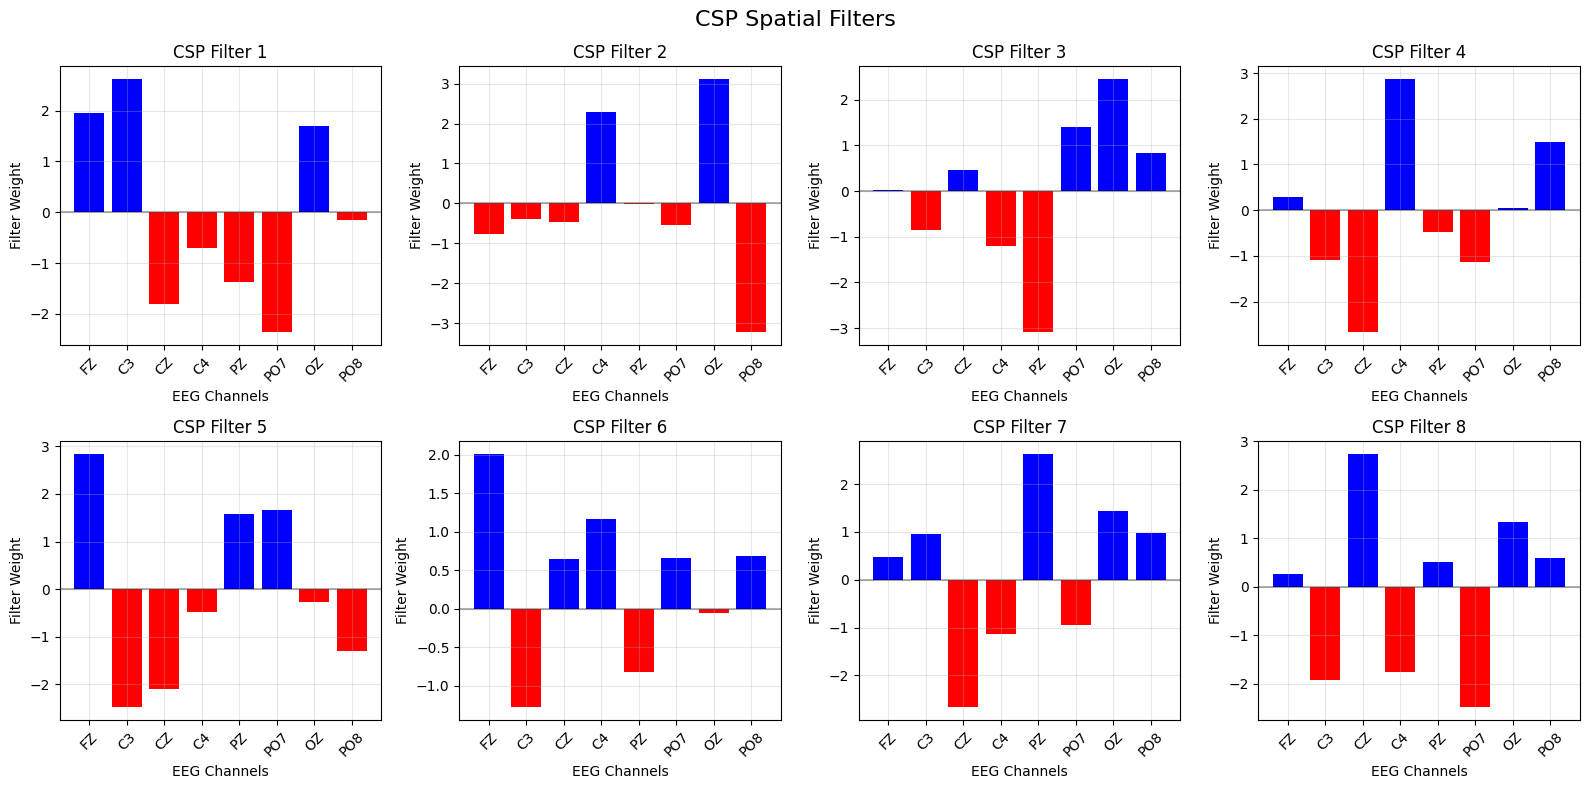


🤖 Creating and training models...


In [9]:
preprocessor, csp,models,train_loader,val_loader = run_ica_csp_eegnet_pipeline('./Dataset/')


🚀 Training EEGNetv4 Baseline...
----------------------------------------


Epoch 1/50 [Val]:   0%|          | 0/2 [00:00<?, ?it/s]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [2, 3, 4, 6]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [1, 2, 4, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)

Epoch 1/50 [Val]:  50%|█████     | 1/2 [00:04<00:04,  4.94s/it]

Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 2, 3, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [0, 1, 2, 4, 5, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)

Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Starting preprocessing for trial with shape: (2250, 8)
✓ Applied bandpass filter (1-40 Hz)
✓ Applied notch filter (50 Hz)
✓ Removed baseline drift
✓ No bad channels detected
✓ Removed ICA components: [3, 4, 5, 6, 7]
✓ Applied standardization
✓ Preprocessing complete. Final shape: (2250, 8)
Epoch 1/50:
  Train Loss: 0.7260
  Val Loss: 0.6860
  Val Acc: 58.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 58.00%
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


Epoch 2/50:
  Train Loss: 0.6955
  Val Loss: 0.6807
  Val Acc: 64.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 64.00%
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.95it/s]


Epoch 3/50:
  Train Loss: 0.6856
  Val Loss: 0.6869
  Val Acc: 54.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 95.24it/s]


Epoch 4/50:
  Train Loss: 0.6812
  Val Loss: 0.6883
  Val Acc: 52.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 105.25it/s]


Epoch 5/50:
  Train Loss: 0.6677
  Val Loss: 0.6850
  Val Acc: 54.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.32it/s]


Epoch 6/50:
  Train Loss: 0.6640
  Val Loss: 0.6973
  Val Acc: 46.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.95it/s]


Epoch 7/50:
  Train Loss: 0.6501
  Val Loss: 0.6923
  Val Acc: 56.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Epoch 8/50:
  Train Loss: 0.6638
  Val Loss: 0.7263
  Val Acc: 52.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Epoch 9/50:
  Train Loss: 0.6406
  Val Loss: 0.7001
  Val Acc: 56.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


Epoch 10/50:
  Train Loss: 0.6331
  Val Loss: 0.7116
  Val Acc: 50.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


Epoch 11/50:
  Train Loss: 0.6282
  Val Loss: 0.7088
  Val Acc: 54.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 90.90it/s]


Epoch 12/50:
  Train Loss: 0.6259
  Val Loss: 0.7105
  Val Acc: 48.00%
  LR: 0.000500
  ⏰ Early stopping triggered after 10 epochs without improvement


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 99.99it/s]



📊 EEGNetv4 Baseline Results:
Validation Accuracy: 0.4800

Classification Report:
              precision    recall  f1-score   support

        Left       0.54      0.50      0.52        28
       Right       0.42      0.45      0.43        22

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.48        50
weighted avg       0.48      0.48      0.48        50


🚀 Training CSP-Net-1...
----------------------------------------


Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Epoch 1/50:
  Train Loss: 0.7192
  Val Loss: 0.7230
  Val Acc: 40.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 40.00%
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 99.99it/s]


Epoch 2/50:
  Train Loss: 0.7067
  Val Loss: 0.7131
  Val Acc: 42.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 42.00%
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


Epoch 3/50:
  Train Loss: 0.6936
  Val Loss: 0.6996
  Val Acc: 46.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 46.00%
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Epoch 4/50:
  Train Loss: 0.6897
  Val Loss: 0.7142
  Val Acc: 50.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 50.00%
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Epoch 5/50:
  Train Loss: 0.6872
  Val Loss: 0.7250
  Val Acc: 40.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.08it/s]


Epoch 6/50:
  Train Loss: 0.6789
  Val Loss: 0.7188
  Val Acc: 46.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Epoch 7/50:
  Train Loss: 0.6708
  Val Loss: 0.7338
  Val Acc: 46.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


Epoch 8/50:
  Train Loss: 0.6638
  Val Loss: 0.7227
  Val Acc: 46.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 76.93it/s]


Epoch 9/50:
  Train Loss: 0.6671
  Val Loss: 0.7245
  Val Acc: 46.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 86.96it/s]


Epoch 10/50:
  Train Loss: 0.6615
  Val Loss: 0.7290
  Val Acc: 40.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 95.24it/s]


Epoch 11/50:
  Train Loss: 0.6590
  Val Loss: 0.7323
  Val Acc: 44.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Epoch 12/50:
  Train Loss: 0.6613
  Val Loss: 0.7259
  Val Acc: 48.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.01it/s]


Epoch 13/50:
  Train Loss: 0.6572
  Val Loss: 0.7253
  Val Acc: 46.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 83.33it/s]


Epoch 14/50:
  Train Loss: 0.6478
  Val Loss: 0.7243
  Val Acc: 44.00%
  LR: 0.000500
  ⏰ Early stopping triggered after 10 epochs without improvement


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]



📊 CSP-Net-1 Results:
Validation Accuracy: 0.4400

Classification Report:
              precision    recall  f1-score   support

        Left       0.50      0.43      0.46        28
       Right       0.38      0.45      0.42        22

    accuracy                           0.44        50
   macro avg       0.44      0.44      0.44        50
weighted avg       0.45      0.44      0.44        50


🚀 Training CSP-Net-2...
----------------------------------------


Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.08it/s]


Epoch 1/50:
  Train Loss: 0.7287
  Val Loss: 0.7003
  Val Acc: 50.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 50.00%
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s]


Epoch 2/50:
  Train Loss: 0.7020
  Val Loss: 0.6996
  Val Acc: 54.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 54.00%
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Epoch 3/50:
  Train Loss: 0.6944
  Val Loss: 0.7126
  Val Acc: 42.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s]


Epoch 4/50:
  Train Loss: 0.6832
  Val Loss: 0.6960
  Val Acc: 56.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 56.00%
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Epoch 5/50:
  Train Loss: 0.6684
  Val Loss: 0.7099
  Val Acc: 50.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Epoch 6/50:
  Train Loss: 0.6684
  Val Loss: 0.6696
  Val Acc: 56.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Epoch 7/50:
  Train Loss: 0.6705
  Val Loss: 0.6856
  Val Acc: 52.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Epoch 8/50:
  Train Loss: 0.6680
  Val Loss: 0.6803
  Val Acc: 62.00%
  LR: 0.001000
  ✅ New best model! Validation accuracy: 62.00%
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Epoch 9/50:
  Train Loss: 0.6489
  Val Loss: 0.6823
  Val Acc: 58.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


Epoch 10/50:
  Train Loss: 0.6500
  Val Loss: 0.6766
  Val Acc: 58.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Epoch 11/50:
  Train Loss: 0.6459
  Val Loss: 0.6875
  Val Acc: 58.00%
  LR: 0.001000
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]


Epoch 12/50:
  Train Loss: 0.6400
  Val Loss: 0.6863
  Val Acc: 62.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s]


Epoch 13/50:
  Train Loss: 0.6377
  Val Loss: 0.6854
  Val Acc: 60.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 66.67it/s]


Epoch 14/50:
  Train Loss: 0.6349
  Val Loss: 0.6816
  Val Acc: 66.00%
  LR: 0.000500
  ✅ New best model! Validation accuracy: 66.00%
------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 79.99it/s]


Epoch 15/50:
  Train Loss: 0.6231
  Val Loss: 0.6915
  Val Acc: 64.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Epoch 16/50:
  Train Loss: 0.6254
  Val Loss: 0.6941
  Val Acc: 50.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s]


Epoch 17/50:
  Train Loss: 0.6106
  Val Loss: 0.6987
  Val Acc: 56.00%
  LR: 0.000500
------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Epoch 18/50:
  Train Loss: 0.6221
  Val Loss: 0.7103
  Val Acc: 54.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 68.97it/s]


Epoch 19/50:
  Train Loss: 0.6094
  Val Loss: 0.7040
  Val Acc: 54.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Epoch 20/50:
  Train Loss: 0.6109
  Val Loss: 0.7063
  Val Acc: 56.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 80.01it/s]


Epoch 21/50:
  Train Loss: 0.6074
  Val Loss: 0.7010
  Val Acc: 56.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 74.08it/s]


Epoch 22/50:
  Train Loss: 0.6155
  Val Loss: 0.6998
  Val Acc: 56.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]


Epoch 23/50:
  Train Loss: 0.6092
  Val Loss: 0.7019
  Val Acc: 58.00%
  LR: 0.000250
------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Epoch 24/50:
  Train Loss: 0.6085
  Val Loss: 0.7038
  Val Acc: 60.00%
  LR: 0.000125
  ⏰ Early stopping triggered after 10 epochs without improvement


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s]



📊 CSP-Net-2 Results:
Validation Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

        Left       0.65      0.61      0.63        28
       Right       0.54      0.59      0.57        22

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50


📈 Final Model Comparison:
EEGNetv4 Baseline: 0.4800
CSP-Net-1: 0.4400
CSP-Net-2: 0.6000


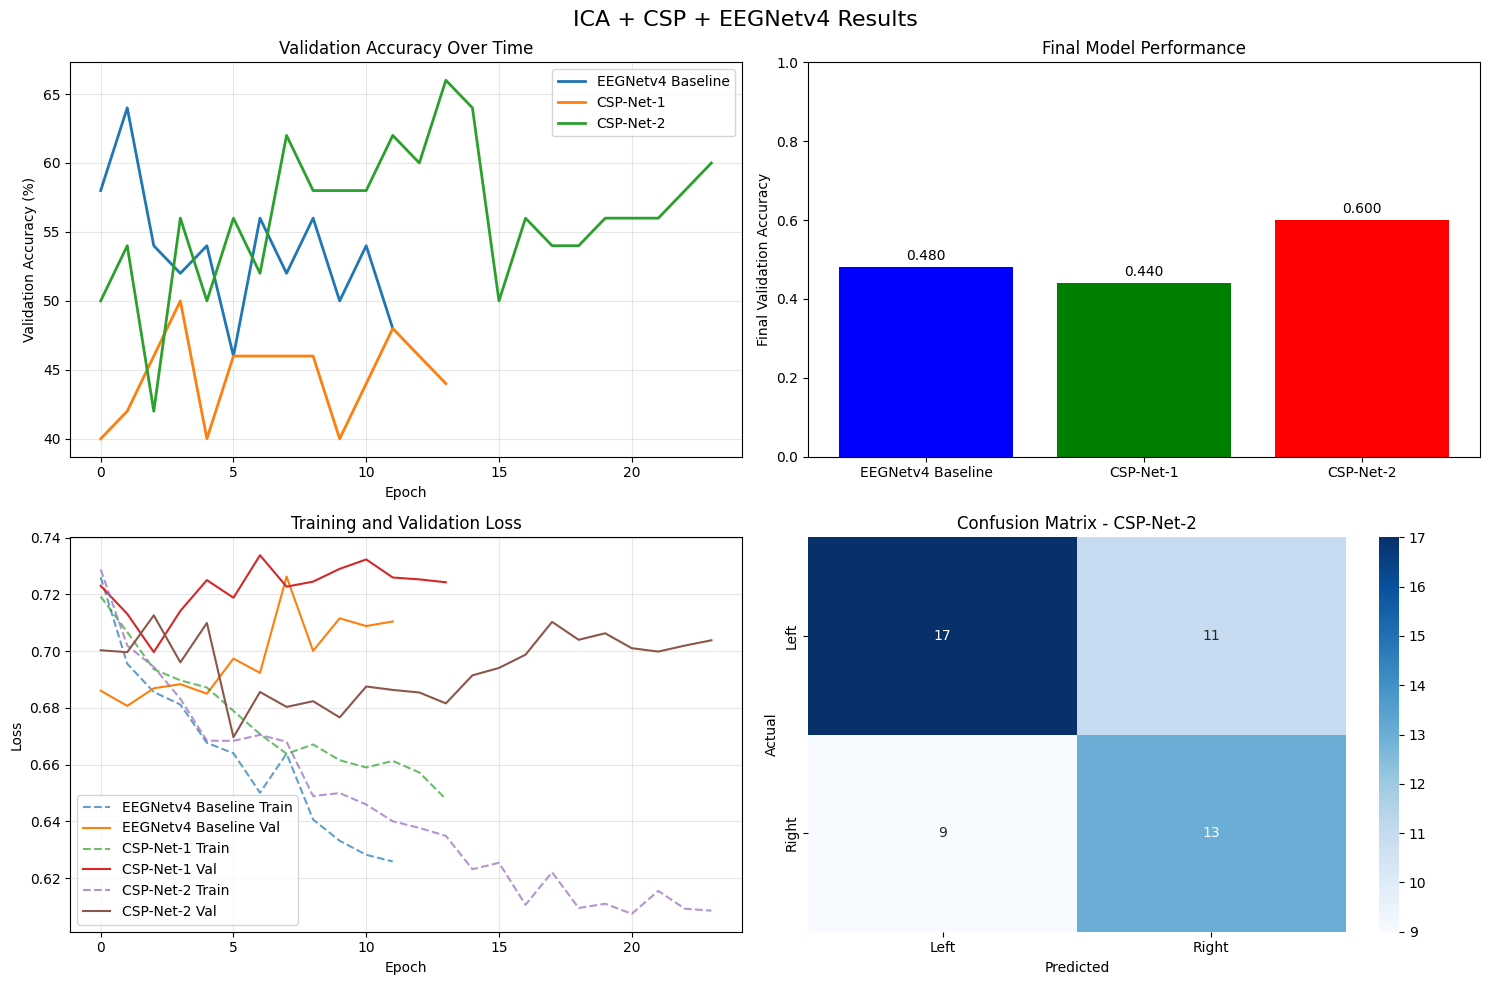

In [10]:
results=train_CPS_model(verbose=True,models=models,train_loader=train_loader,val_loader=val_loader, num_epochs=50)